# Dimensionality Reduction - Making High-Dimensional Data Understandable

This notebook will teach you how to reduce the complexity of your data whilst preserving the most important information.

**What we'll learn:**
1. Understanding the curse of dimensionality
2. Principal Component Analysis (PCA) - finding the main patterns
3. UMAP (Uniform Manifold Approximation) - preserving local structure (in theory)
4. When to use each technique
5. Visualising high-dimensional data in 2D/3D
6. Practical applications

**What is dimensionality reduction?**
Imagine you have a dataset with 100 features, but only 3-4 of them really matter for understanding your data. Dimensionality reduction finds the features, or combination of features, that capture the most important information!

**Prerequisites:**
- Complete the clustering analysis notebook first
- Have your clean data ready
- Basic understanding of data preprocessing

**Instructions:**
- Run each cell in order
- Try different numbers of components
- Compare PCA and UMAP results!

In [1]:
# Import libraries for dimensionality reduction and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

# For UMAP, we need to install it first if not available
try:
    import umap.umap_ as umap
    print("UMAP imported successfully!")
except ImportError:
    print("Installing UMAP...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn"])
    import umap.umap_ as umap
    print("UMAP installed and imported successfully!")

# Set up nice-looking plots
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to explore dimensionality reduction!")

UMAP imported successfully!
Libraries imported successfully!
Ready to explore dimensionality reduction!


## 1. Load and Prepare Your Data

Let's start by loading our clean data and understanding its dimensionality.

In [2]:
# Load your clean data
df = pd.read_csv('../datasets/cleaned_data.csv')

print(f"Data loaded successfully!")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")

# Show basic information
print(f"\n📊 Dataset Overview:")
print(f"- Original dimensions: {df.shape[1]} features")
print(f"- Sample size: {df.shape[0]} observations")

# Look at the data
print("\nFirst few rows:")
df.head()

Data loaded successfully!
Shape: 64620 rows × 11 columns

📊 Dataset Overview:
- Original dimensions: 11 features
- Sample size: 64620 observations

First few rows:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,SE,FT,Solutions Engineer,214000,USD,214000,US,100,US,M
1,2025,MI,FT,Data Engineer,158800,USD,158800,AU,0,AU,M
2,2025,MI,FT,Data Engineer,139200,USD,139200,AU,0,AU,M
3,2025,EN,FT,Data Engineer,90000,USD,90000,US,0,US,M
4,2025,EN,FT,Data Engineer,80000,USD,80000,US,0,US,M


In [3]:
# Examine our features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print("🔍 FEATURE ANALYSIS")
print("=" * 50)

print(f"📊 Numerical features ({len(numerical_features)}):")
for i, feature in enumerate(numerical_features, 1):
    variance = df[feature].var()
    print(f"{i}. {feature} (variance: {variance:.1f})")

print(f"\n📝 Categorical features ({len(categorical_features)}):")
for i, feature in enumerate(categorical_features, 1):
    n_categories = df[feature].nunique()
    print(f"{i}. {feature} ({n_categories} categories)")

print(f"\n💡 Why dimensionality reduction matters:")
print(f"- With {df.shape[1]} features, visualisation is impossible")
print(f"- Some features might be redundant or correlated")
print(f"- Reducing dimensions makes data easier to understand and plot")
print(f"- Can improve machine learning model performance")

🔍 FEATURE ANALYSIS
📊 Numerical features (4):
1. work_year (variance: 0.5)
2. salary (variance: 88940176661.5)
3. salary_in_usd (variance: 6010943493.5)
4. remote_ratio (variance: 1844.4)

📝 Categorical features (7):
1. experience_level (4 categories)
2. employment_type (4 categories)
3. job_title (390 categories)
4. salary_currency (26 categories)
5. employee_residence (102 categories)
6. company_location (95 categories)
7. company_size (3 categories)

💡 Why dimensionality reduction matters:
- With 11 features, visualisation is impossible
- Some features might be redundant or correlated
- Reducing dimensions makes data easier to understand and plot
- Can improve machine learning model performance


## 2. Prepare Features for Dimensionality Reduction

We need to create a comprehensive feature matrix, similar to what we did for clustering.

In [4]:
# Create feature matrix with both numerical and categorical features
print("🔧 CREATING COMPREHENSIVE FEATURE MATRIX")
print("=" * 50)

feature_frames = []

# Add all numerical features
if len(numerical_features) > 0:
    X_numerical = df[numerical_features].copy()
    feature_frames.append(X_numerical)
    print(f"✓ Added {len(numerical_features)} numerical features")

# Encode categorical features (limit to reasonable number of categories)
categorical_for_encoding = []
if len(categorical_features) > 0:
    print(f"\n🔤 Encoding categorical features...")
    
    for feature in categorical_features:
        n_categories = df[feature].nunique()
        if n_categories <= 20:  # Only encode features with reasonable categories
            categorical_for_encoding.append(feature)
            print(f"  Including {feature}: {n_categories} categories")
        else:
            print(f"  Skipping {feature}: {n_categories} categories (too many)")
    
    if categorical_for_encoding:
        # One-hot encode selected categorical features
        categorical_encoded_frames = []
        for feature in categorical_for_encoding:
            encoded = pd.get_dummies(df[feature], prefix=feature, drop_first=True)
            categorical_encoded_frames.append(encoded)
        
        X_categorical = pd.concat(categorical_encoded_frames, axis=1)
        feature_frames.append(X_categorical)
        print(f"✓ Encoded {len(categorical_for_encoding)} categorical features")
        print(f"  Created {X_categorical.shape[1]} binary features")

# Combine all features
X = pd.concat(feature_frames, axis=1)
print(f"\n✅ COMPLETE FEATURE MATRIX:")
print(f"   Shape: {X.shape}")
print(f"   Features: {list(X.columns)[:5]}... (showing first 5)")

# Check for any missing values
if X.isnull().sum().sum() > 0:
    print(f"⚠️  Found missing values, filling with median/mode")
    # Fill numerical columns with median
    for col in X.select_dtypes(include=[np.number]).columns:
        X[col] = X[col].fillna(X[col].median())
    # Fill categorical columns with mode
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = X[col].fillna(X[col].mode().iloc[0])

🔧 CREATING COMPREHENSIVE FEATURE MATRIX
✓ Added 4 numerical features

🔤 Encoding categorical features...
  Including experience_level: 4 categories
  Including employment_type: 4 categories
  Skipping job_title: 390 categories (too many)
  Skipping salary_currency: 26 categories (too many)
  Skipping employee_residence: 102 categories (too many)
  Skipping company_location: 95 categories (too many)
  Including company_size: 3 categories
✓ Encoded 3 categorical features
  Created 8 binary features

✅ COMPLETE FEATURE MATRIX:
   Shape: (64620, 12)
   Features: ['work_year', 'salary', 'salary_in_usd', 'remote_ratio', 'experience_level_EX']... (showing first 5)


In [5]:
# Standardise features (essential for dimensionality reduction!)
print("⚖️ STANDARDISING FEATURES")
print("=" * 50)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("✓ Features standardised!")
print(f"All features now have mean ≈ 0 and standard deviation ≈ 1")

# Show the standardisation effect
print(f"\nBefore standardisation:")
# Only show ranges for numerical features to avoid boolean arithmetic errors
numerical_columns = X.select_dtypes(include=[np.number]).columns
if len(numerical_columns) > 0:
    numerical_ranges = X[numerical_columns].max() - X[numerical_columns].min()
    print(f"  Numerical feature ranges: {numerical_ranges.describe()}")
else:
    print(f"  No numerical features to show ranges for")

print(f"\nAfter standardisation:")
standardised_ranges = X_scaled_df.max() - X_scaled_df.min()
print(f"  All feature ranges: {standardised_ranges.describe()}")

print(f"\n🔍 Why standardisation is crucial:")
print(f"- PCA is sensitive to feature scales")
print(f"- UMAP also benefits from standardised features")
print(f"- Prevents features with large values from dominating")

⚖️ STANDARDISING FEATURES
✓ Features standardised!
All features now have mean ≈ 0 and standard deviation ≈ 1

Before standardisation:
  Numerical feature ranges: count    4.000000e+00
mean     7.792776e+06
std      1.506669e+07
min      5.000000e+00
25%      7.625000e+01
50%      3.925500e+05
75%      8.185250e+06
max      3.038600e+07
dtype: float64

After standardisation:
  All feature ranges: count     12.000000
mean      20.179885
std       30.710221
min        2.002732
25%        4.617566
50%        8.350305
75%       15.140274
max      101.889141
dtype: float64

🔍 Why standardisation is crucial:
- PCA is sensitive to feature scales
- UMAP also benefits from standardised features
- Prevents features with large values from dominating


## 3. Principal Component Analysis (PCA)

PCA finds the directions of maximum variance in your data. Think of it as finding the "best camera angles" to view your data!

In [6]:
# Apply PCA to find the optimal number of components
print("🔍 ANALYSING PRINCIPAL COMPONENTS")
print("=" * 50)

# Fit PCA with all possible components
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

print(f"Total features: {X_scaled.shape[1]}")
print(f"Total variance explained by all components: {cumulative_variance[-1]:.3f}")

# Find how many components explain 90% and 95% of variance
components_90 = np.argmax(cumulative_variance >= 0.90) + 1
components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\n📊 Variance explanation:")
print(f"- {components_90} components explain 90% of variance")
print(f"- {components_95} components explain 95% of variance")
print(f"- This means we can reduce from {X_scaled.shape[1]} to {components_90} dimensions!")

# Show top components
print(f"\nTop 10 components and their variance:")
for i in range(min(10, len(pca_full.explained_variance_ratio_))):
    print(f"PC{i+1}: {pca_full.explained_variance_ratio_[i]:.3f} ({pca_full.explained_variance_ratio_[i]*100:.1f}%)")

🔍 ANALYSING PRINCIPAL COMPONENTS
Total features: 12
Total variance explained by all components: 1.000

📊 Variance explanation:
- 9 components explain 90% of variance
- 10 components explain 95% of variance
- This means we can reduce from 12 to 9 dimensions!

Top 10 components and their variance:
PC1: 0.158 (15.8%)
PC2: 0.141 (14.1%)
PC3: 0.127 (12.7%)
PC4: 0.101 (10.1%)
PC5: 0.085 (8.5%)
PC6: 0.083 (8.3%)
PC7: 0.081 (8.1%)
PC8: 0.069 (6.9%)
PC9: 0.062 (6.2%)
PC10: 0.053 (5.3%)


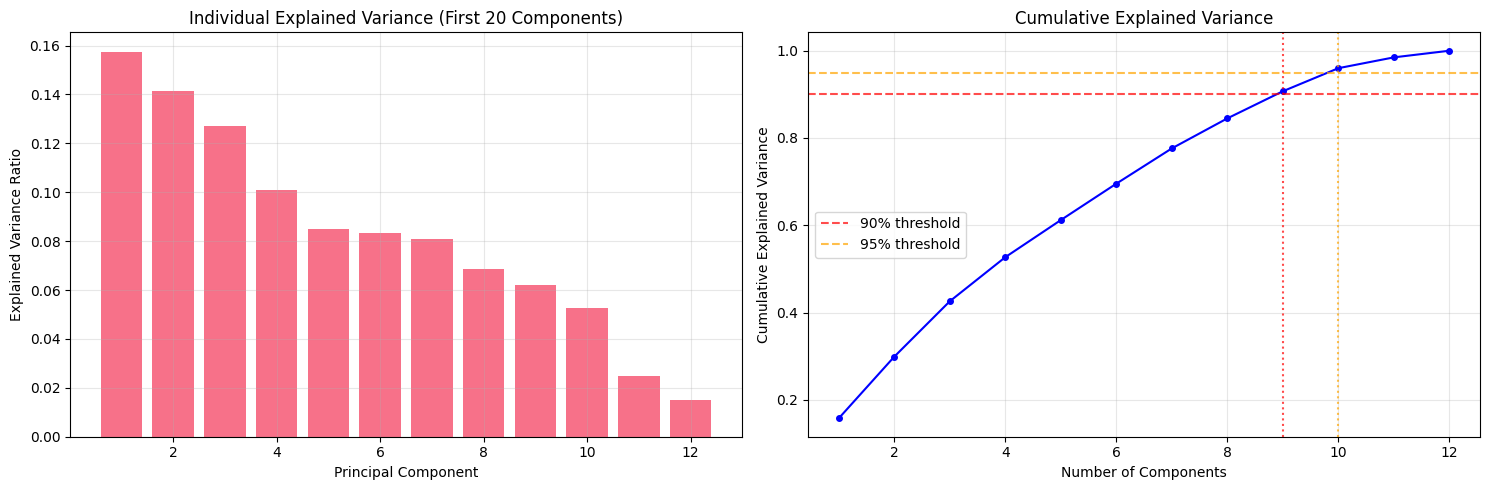

How to interpret these plots:
• Left: How much each component contributes individually
• Right: How much variance is captured as we add more components
• The 'elbow' in the right plot suggests optimal number of components


In [7]:
# Visualise the explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Individual explained variance
ax1.bar(range(1, min(21, len(pca_full.explained_variance_ratio_) + 1)), 
        pca_full.explained_variance_ratio_[:20])
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Individual Explained Variance (First 20 Components)')
ax1.grid(True, alpha=0.3)

# Cumulative explained variance
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-', markersize=4)
ax2.axhline(y=0.90, color='r', linestyle='--', alpha=0.7, label='90% threshold')
ax2.axhline(y=0.95, color='orange', linestyle='--', alpha=0.7, label='95% threshold')
ax2.axvline(x=components_90, color='r', linestyle=':', alpha=0.7)
ax2.axvline(x=components_95, color='orange', linestyle=':', alpha=0.7)
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("How to interpret these plots:")
print("• Left: How much each component contributes individually")
print("• Right: How much variance is captured as we add more components")
print("• The 'elbow' in the right plot suggests optimal number of components")

In [8]:
# Apply PCA for 2D and 3D visualisation
print("🎨 CREATING 2D AND 3D VISUALISATIONS")
print("=" * 50)

# 2D PCA
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# 3D PCA  
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Also create a reduced dataset with optimal components
pca_optimal = PCA(n_components=components_90, random_state=42)
X_pca_optimal = pca_optimal.fit_transform(X_scaled)

print(f"✓ 2D PCA: {X_scaled.shape[1]} → 2 dimensions")
print(f"  Variance explained: {pca_2d.explained_variance_ratio_.sum():.3f}")

print(f"✓ 3D PCA: {X_scaled.shape[1]} → 3 dimensions") 
print(f"  Variance explained: {pca_3d.explained_variance_ratio_.sum():.3f}")

print(f"✓ Optimal PCA: {X_scaled.shape[1]} → {components_90} dimensions")
print(f"  Variance explained: {pca_optimal.explained_variance_ratio_.sum():.3f}")

# Store PCA results in DataFrame for easy plotting
pca_results_df = pd.DataFrame({
    'PC1': X_pca_2d[:, 0],
    'PC2': X_pca_2d[:, 1],
    'PC3': X_pca_3d[:, 2] if X_pca_3d.shape[1] > 2 else np.zeros(len(X_pca_2d))
})

print(f"\n📊 PCA Results Summary:")
print(f"- Original dimensions: {X_scaled.shape[1]}")
print(f"- 2D captures: {pca_2d.explained_variance_ratio_.sum()*100:.1f}% of variance")
print(f"- 3D captures: {pca_3d.explained_variance_ratio_.sum()*100:.1f}% of variance") 
print(f"- {components_90}D captures: {pca_optimal.explained_variance_ratio_.sum()*100:.1f}% of variance")

🎨 CREATING 2D AND 3D VISUALISATIONS
✓ 2D PCA: 12 → 2 dimensions
  Variance explained: 0.299
✓ 3D PCA: 12 → 3 dimensions
  Variance explained: 0.426
✓ Optimal PCA: 12 → 9 dimensions
  Variance explained: 0.907

📊 PCA Results Summary:
- Original dimensions: 12
- 2D captures: 29.9% of variance
- 3D captures: 42.6% of variance
- 9D captures: 90.7% of variance


## 4. UMAP (Uniform Manifold Approximation and Projection)

UMAP preserves local structure better than PCA. It's excellent for visualising complex, non-linear relationships!

In [9]:
# Apply UMAP for 2D and 3D visualisation
print("🗺️ APPLYING UMAP DIMENSIONALITY REDUCTION")
print("=" * 50)

# For large datasets, we might want to sample for faster computation
sample_size = min(10000, len(X_scaled))  # Use up to 10,000 points
if len(X_scaled) > sample_size:
    print(f"Using a sample of {sample_size} points for UMAP (from {len(X_scaled)} total)")
    sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
    X_sample = X_scaled[sample_indices]
    df_sample = df.iloc[sample_indices].reset_index(drop=True)
else:
    X_sample = X_scaled
    df_sample = df.copy()
    sample_indices = np.arange(len(X_scaled))

print(f"Running UMAP on {len(X_sample)} data points...")

# 2D UMAP
print("Computing 2D UMAP...")
umap_2d = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap_2d = umap_2d.fit_transform(X_sample)

# 3D UMAP
print("Computing 3D UMAP...")
umap_3d = umap.UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap_3d = umap_3d.fit_transform(X_sample)

print("✓ UMAP computations complete!")

# Store UMAP results
umap_results_df = pd.DataFrame({
    'UMAP1': X_umap_2d[:, 0],
    'UMAP2': X_umap_2d[:, 1],
    'UMAP3': X_umap_3d[:, 2]
})

print(f"\n📊 UMAP Results Summary:")
print(f"- Processed {len(X_sample)} data points")
print(f"- 2D UMAP coordinates range: [{X_umap_2d.min():.1f}, {X_umap_2d.max():.1f}]")
print(f"- 3D UMAP coordinates range: [{X_umap_3d.min():.1f}, {X_umap_3d.max():.1f}]")

print(f"\n🔍 UMAP vs PCA:")
print(f"- PCA: Linear transformation, preserves global structure")
print(f"- UMAP: Non-linear transformation, preserves local structure")
print(f"- UMAP often reveals clusters and local patterns better")

🗺️ APPLYING UMAP DIMENSIONALITY REDUCTION
Using a sample of 10000 points for UMAP (from 64620 total)
Running UMAP on 10000 data points...
Computing 2D UMAP...
Computing 3D UMAP...
✓ UMAP computations complete!

📊 UMAP Results Summary:
- Processed 10000 data points
- 2D UMAP coordinates range: [-23.8, 26.0]
- 3D UMAP coordinates range: [-11.6, 25.0]

🔍 UMAP vs PCA:
- PCA: Linear transformation, preserves global structure
- UMAP: Non-linear transformation, preserves local structure
- UMAP often reveals clusters and local patterns better


## 5. Compare PCA and UMAP Visualisations

Let's see how PCA and UMAP represent our data differently!

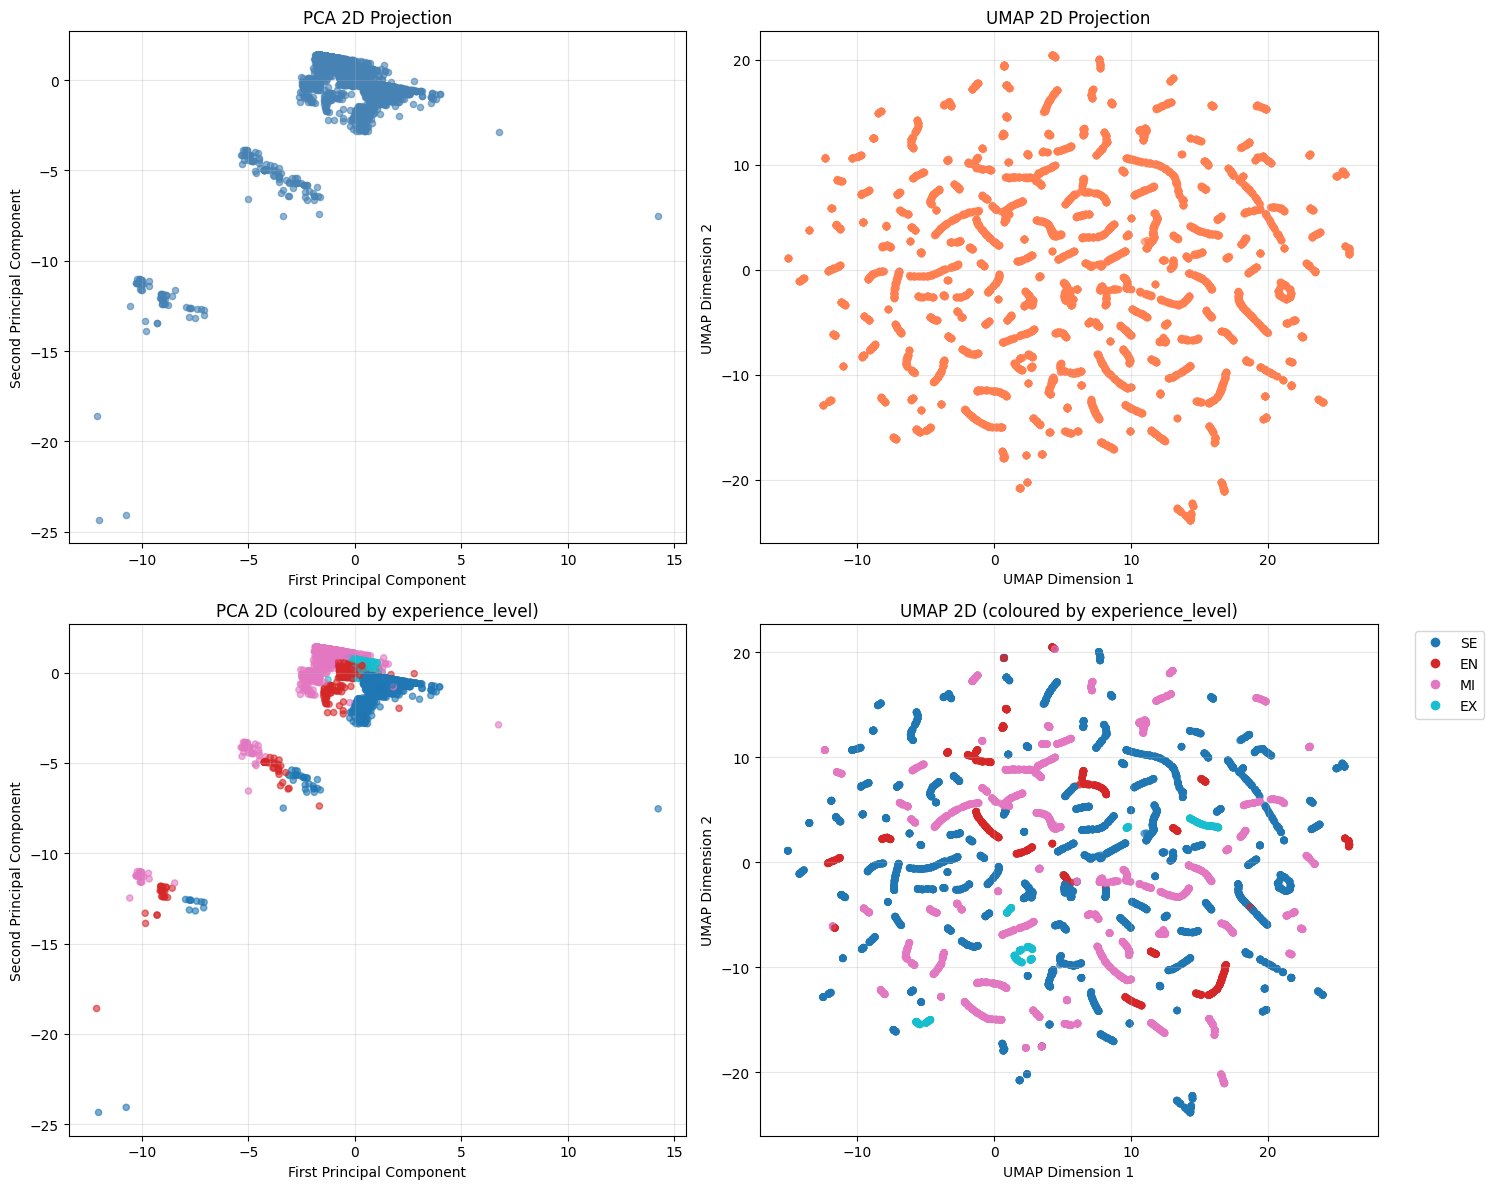

🎨 Visualisation Comparison:
• PCA (blue): Shows global structure, linear relationships
• UMAP (coral): Shows local structure, non-linear relationships
• Look for clusters, patterns, and separations
• UMAP often reveals more detailed local structure


In [10]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# PCA 2D (using sample if needed)
pca_sample_indices = sample_indices if len(X_scaled) > sample_size else np.arange(len(X_scaled))
X_pca_sample = X_pca_2d[pca_sample_indices] if len(X_scaled) > sample_size else X_pca_2d

scatter1 = axes[0, 0].scatter(X_pca_sample[:, 0], X_pca_sample[:, 1], 
                              alpha=0.6, s=20, c='steelblue')
axes[0, 0].set_xlabel('First Principal Component')
axes[0, 0].set_ylabel('Second Principal Component')
axes[0, 0].set_title('PCA 2D Projection')
axes[0, 0].grid(True, alpha=0.3)

# UMAP 2D
scatter2 = axes[0, 1].scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], 
                              alpha=0.6, s=20, c='coral')
axes[0, 1].set_xlabel('UMAP Dimension 1')
axes[0, 1].set_ylabel('UMAP Dimension 2')
axes[0, 1].set_title('UMAP 2D Projection')
axes[0, 1].grid(True, alpha=0.3)

# If we have categorical features, colour by the first one
if len(categorical_features) > 0:
    color_feature = categorical_features[0]
    
    # Get unique categories and assign colours
    unique_categories = df_sample[color_feature].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_categories)))
    color_map = dict(zip(unique_categories, colors))
    
    # Create colour array
    point_colors = [color_map[cat] for cat in df_sample[color_feature]]
    
    # PCA with categories
    scatter3 = axes[1, 0].scatter(X_pca_sample[:, 0], X_pca_sample[:, 1], 
                                  c=point_colors, alpha=0.6, s=20)
    axes[1, 0].set_xlabel('First Principal Component')
    axes[1, 0].set_ylabel('Second Principal Component')
    axes[1, 0].set_title(f'PCA 2D (coloured by {color_feature})')
    axes[1, 0].grid(True, alpha=0.3)
    
    # UMAP with categories
    scatter4 = axes[1, 1].scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], 
                                  c=point_colors, alpha=0.6, s=20)
    axes[1, 1].set_xlabel('UMAP Dimension 1')
    axes[1, 1].set_ylabel('UMAP Dimension 2')
    axes[1, 1].set_title(f'UMAP 2D (coloured by {color_feature})')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor=color_map[cat], markersize=8, label=cat)
                       for cat in unique_categories[:10]]  # Show first 10 categories
    axes[1, 1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

else:
    # If no categorical features, show density plots
    axes[1, 0].hexbin(X_pca_sample[:, 0], X_pca_sample[:, 1], gridsize=30, cmap='Blues')
    axes[1, 0].set_xlabel('First Principal Component')
    axes[1, 0].set_ylabel('Second Principal Component')
    axes[1, 0].set_title('PCA 2D (density)')
    
    axes[1, 1].hexbin(X_umap_2d[:, 0], X_umap_2d[:, 1], gridsize=30, cmap='Reds')
    axes[1, 1].set_xlabel('UMAP Dimension 1')
    axes[1, 1].set_ylabel('UMAP Dimension 2')
    axes[1, 1].set_title('UMAP 2D (density)')

plt.tight_layout()
plt.show()

print("🎨 Visualisation Comparison:")
print("• PCA (blue): Shows global structure, linear relationships")
print("• UMAP (coral): Shows local structure, non-linear relationships")
print("• Look for clusters, patterns, and separations")
print("• UMAP often reveals more detailed local structure")

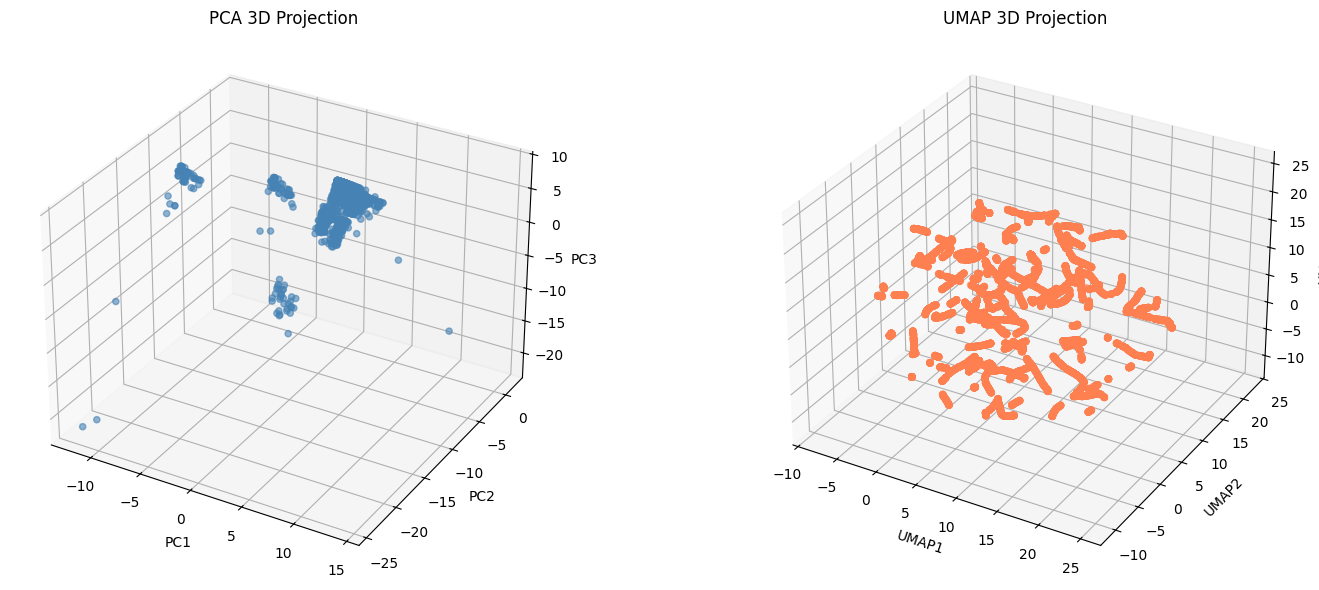

🌐 3D Visualisation Benefits:
• Shows more complex relationships than 2D
• Can reveal layered structures in data
• Interactive rotation helps explore different angles
• 3D UMAP often shows clearer cluster separation


In [11]:
# Create 3D visualisations
fig = plt.figure(figsize=(16, 6))

# 3D PCA
ax1 = fig.add_subplot(121, projection='3d')
X_pca_3d_sample = X_pca_3d[pca_sample_indices] if len(X_scaled) > sample_size else X_pca_3d

scatter1 = ax1.scatter(X_pca_3d_sample[:, 0], X_pca_3d_sample[:, 1], X_pca_3d_sample[:, 2], 
                       alpha=0.6, s=20, c='steelblue')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('PCA 3D Projection')

# 3D UMAP
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2], 
                       alpha=0.6, s=20, c='coral')
ax2.set_xlabel('UMAP1')
ax2.set_ylabel('UMAP2')
ax2.set_zlabel('UMAP3')
ax2.set_title('UMAP 3D Projection')

plt.tight_layout()
plt.show()

print("🌐 3D Visualisation Benefits:")
print("• Shows more complex relationships than 2D")
print("• Can reveal layered structures in data")
print("• Interactive rotation helps explore different angles")
print("• 3D UMAP often shows clearer cluster separation")

## 6. Analyse the Components

Let's understand what the principal components actually represent!

🔍 ANALYSING PRINCIPAL COMPONENTS
Top contributors to each principal component:

📊 PC1 (explains 15.8% of variance):
1. experience_level_SE: 0.784
2. experience_level_MI: 0.716
3. employment_type_FT: 0.493
4. employment_type_PT: 0.466
5. salary_in_usd: 0.445

📊 PC2 (explains 14.1% of variance):
1. employment_type_FT: 0.689
2. employment_type_PT: 0.651
3. experience_level_MI: 0.501
4. experience_level_SE: 0.467
5. company_size_S: 0.310


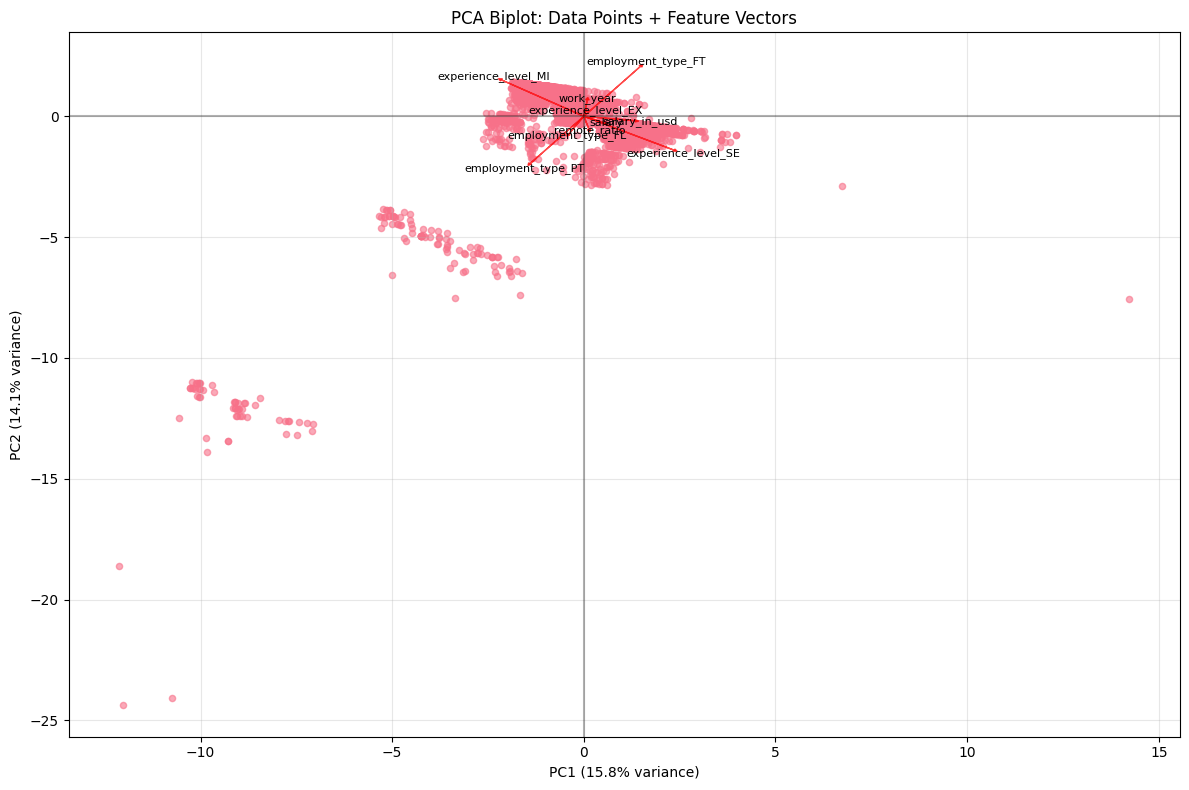


🎯 Understanding the Biplot:
• Points show your data in the new 2D space
• Red arrows show how original features relate to PCs
• Longer arrows = more important features
• Arrows pointing same direction = correlated features


In [12]:
# Analyse PCA components
print("🔍 ANALYSING PRINCIPAL COMPONENTS")
print("=" * 50)

# Get the loadings (how much each original feature contributes to each PC)
loadings = pca_2d.components_.T * np.sqrt(pca_2d.explained_variance_)
loadings_df = pd.DataFrame(loadings, 
                          columns=['PC1', 'PC2'], 
                          index=X.columns)

print("Top contributors to each principal component:")
print("\n📊 PC1 (explains {:.1f}% of variance):".format(pca_2d.explained_variance_ratio_[0]*100))
pc1_contributors = loadings_df['PC1'].abs().sort_values(ascending=False)
for i, (feature, loading) in enumerate(pc1_contributors.head(5).items()):
    print(f"{i+1}. {feature}: {loading:.3f}")

print("\n📊 PC2 (explains {:.1f}% of variance):".format(pca_2d.explained_variance_ratio_[1]*100))
pc2_contributors = loadings_df['PC2'].abs().sort_values(ascending=False)
for i, (feature, loading) in enumerate(pc2_contributors.head(5).items()):
    print(f"{i+1}. {feature}: {loading:.3f}")

# Create a biplot to show both data points and feature vectors
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the transformed data points
scatter = ax.scatter(X_pca_sample[:, 0], X_pca_sample[:, 1], alpha=0.6, s=20)

# Plot feature vectors (scaled for visibility)
scale_factor = 3
for i, (feature, row) in enumerate(loadings_df.iterrows()):
    if i < 10:  # Show only first 10 features to avoid clutter
        ax.arrow(0, 0, row['PC1']*scale_factor, row['PC2']*scale_factor, 
                head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.7)
        ax.text(row['PC1']*scale_factor*1.1, row['PC2']*scale_factor*1.1, 
                feature, fontsize=8, ha='center', va='center')

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)')
ax.set_title('PCA Biplot: Data Points + Feature Vectors')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎯 Understanding the Biplot:")
print("• Points show your data in the new 2D space")
print("• Red arrows show how original features relate to PCs")
print("• Longer arrows = more important features")
print("• Arrows pointing same direction = correlated features")

## 7. Practical Applications

Let's explore how to use dimensionality reduction in real-world scenarios!

In [14]:
# Save the dimensionality reduction results
print("💾 SAVING DIMENSIONALITY REDUCTION RESULTS")
print("=" * 50)

# Create comprehensive results dataset
results_df = df.copy()

# Add PCA results (for all data points)
results_df['PCA_1'] = X_pca_2d[:, 0]
results_df['PCA_2'] = X_pca_2d[:, 1]

# Add UMAP results (map back to original indices if we used sampling)
if len(X_scaled) > sample_size:
    # Create full arrays filled with NaN
    umap_1_full = np.full(len(df), np.nan)
    umap_2_full = np.full(len(df), np.nan)
    
    # Fill in the sampled values
    umap_1_full[sample_indices] = X_umap_2d[:, 0]
    umap_2_full[sample_indices] = X_umap_2d[:, 1]
    
    results_df['UMAP_1'] = umap_1_full
    results_df['UMAP_2'] = umap_2_full
    print(f"⚠️  UMAP results only available for {len(sample_indices)} sampled points")
else:
    results_df['UMAP_1'] = X_umap_2d[:, 0]
    results_df['UMAP_2'] = X_umap_2d[:, 1]

# Save to CSV
results_df.to_csv('dimensionality_reduction_results.csv', index=False)
print("✓ Results saved to 'dimensionality_reduction_results.csv'")

print(f"\n📋 Dataset now includes:")
print(f"- Original features: {len(df.columns)} columns")
print(f"- PCA coordinates: 2 columns") 
print(f"- UMAP coordinates: 2 columns")
print(f"- Total: {len(results_df.columns)} columns")

💾 SAVING DIMENSIONALITY REDUCTION RESULTS
⚠️  UMAP results only available for 10000 sampled points
✓ Results saved to 'dimensionality_reduction_results.csv'

📋 Dataset now includes:
- Original features: 11 columns
- PCA coordinates: 2 columns
- UMAP coordinates: 2 columns
- Total: 15 columns


In [18]:
# Demonstrate practical applications
print("💡 PRACTICAL APPLICATIONS OF DIMENSIONALITY REDUCTION")
print("=" * 50)

print("1. 📊 Data Visualisation:")
print("   - Impossible to plot 50+ dimensional data")
print("   - PCA/UMAP reduce to 2D/3D for plotting")
print("   - Reveals patterns invisible in high dimensions")

print("\n2. 🚀 Machine Learning Preprocessing:")
print("   - Reduces computational cost")
print("   - Can improve model performance")
print("   - Removes noisy/redundant features")

print("\n3. 🔍 Anomaly Detection:")
print("   - Outliers easier to spot in 2D/3D")
print("   - Large distances in reduced space = anomalies")
print("   - Useful for fraud detection, quality control")

print("\n4. 🎯 Feature Engineering:")
print("   - Principal components become new features")
print("   - Often better than original features")
print("   - Removes multicollinearity issues")

print("\n5. 📈 Exploratory Data Analysis:")
print("   - Understand data structure quickly")
print("   - Identify natural clusters")
print("   - Guide further analysis")




💡 PRACTICAL APPLICATIONS OF DIMENSIONALITY REDUCTION
1. 📊 Data Visualisation:
   - Impossible to plot 50+ dimensional data
   - PCA/UMAP reduce to 2D/3D for plotting
   - Reveals patterns invisible in high dimensions

2. 🚀 Machine Learning Preprocessing:
   - Reduces computational cost
   - Can improve model performance
   - Removes noisy/redundant features

3. 🔍 Anomaly Detection:
   - Outliers easier to spot in 2D/3D
   - Large distances in reduced space = anomalies
   - Useful for fraud detection, quality control

4. 🎯 Feature Engineering:
   - Principal components become new features
   - Often better than original features
   - Removes multicollinearity issues

5. 📈 Exploratory Data Analysis:
   - Understand data structure quickly
   - Identify natural clusters
   - Guide further analysis


🔬 DIMENSIONALITY REDUCTION FOR CLUSTERING
Clustering in original space...
Clustering in PCA space...


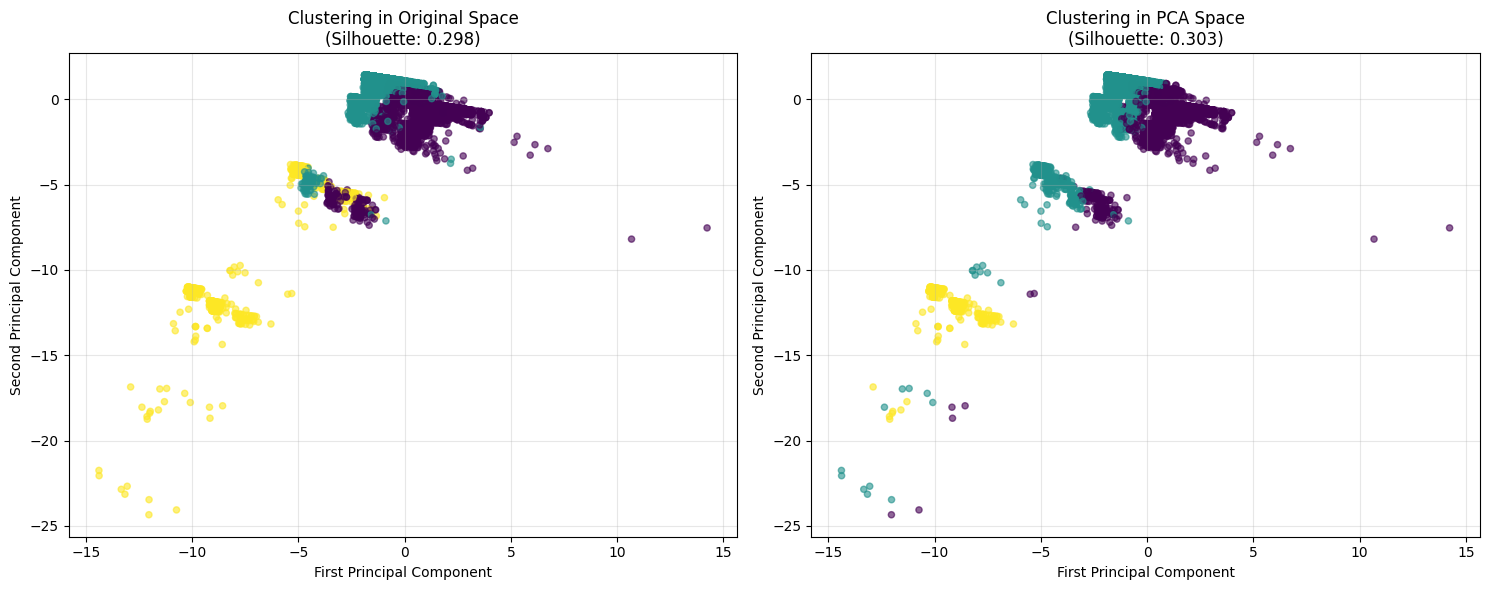

📊 Clustering Comparison:
- Original space (12D): Silhouette = 0.298
- PCA space (9D): Silhouette = 0.303
✓ PCA improved clustering quality!
  Benefits: Faster computation + better separation

💡 Computational Benefits:
- Original: 12 features × 64620 points = 775,440 values
- PCA: 9 features × 64620 points = 581,580 values
- Reduction: 25.0% fewer values!


In [19]:
# Compare clustering results with and without dimensionality reduction
print("🔬 DIMENSIONALITY REDUCTION FOR CLUSTERING")
print("=" * 50)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Original high-dimensional clustering
print("Clustering in original space...")
kmeans_original = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_original = kmeans_original.fit_predict(X_scaled)
silhouette_original = silhouette_score(X_scaled, labels_original)

# PCA-reduced clustering  
print("Clustering in PCA space...")
kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca_optimal)
silhouette_pca = silhouette_score(X_pca_optimal, labels_pca)

# 2D visualisation of clustering results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Original space clusters (projected to 2D PCA for visualisation)
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                          c=labels_original, cmap='viridis', alpha=0.6, s=20)
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component') 
axes[0].set_title(f'Clustering in Original Space\n(Silhouette: {silhouette_original:.3f})')
axes[0].grid(True, alpha=0.3)

# PCA space clusters
scatter2 = axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                          c=labels_pca, cmap='viridis', alpha=0.6, s=20)
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
axes[1].set_title(f'Clustering in PCA Space\n(Silhouette: {silhouette_pca:.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Clustering Comparison:")
print(f"- Original space ({X_scaled.shape[1]}D): Silhouette = {silhouette_original:.3f}")
print(f"- PCA space ({components_90}D): Silhouette = {silhouette_pca:.3f}")

if silhouette_pca > silhouette_original:
    print("✓ PCA improved clustering quality!")
    print("  Benefits: Faster computation + better separation")
else:
    print("• Original space performed better")
    print("  This suggests important information in discarded components")

print(f"\n💡 Computational Benefits:")
print(f"- Original: {X_scaled.shape[1]} features × {len(X_scaled)} points = {X_scaled.shape[1] * len(X_scaled):,} values")
print(f"- PCA: {components_90} features × {len(X_scaled)} points = {components_90 * len(X_scaled):,} values")
print(f"- Reduction: {(1 - (components_90 * len(X_scaled)) / (X_scaled.shape[1] * len(X_scaled)))*100:.1f}% fewer values!")

## 8. When to Use PCA vs UMAP

Understanding when to use each technique is crucial for effective analysis!

In [20]:
# Guidelines for choosing between PCA and UMAP
print("🎯 CHOOSING BETWEEN PCA AND UMAP")
print("=" * 50)

print("🔬 Use PCA when:")
print("• You want to understand global data structure")
print("• You need interpretable components (feature importance)")
print("• You want to reduce data size for machine learning")
print("• You have linear relationships in your data")
print("• You need fast, deterministic results")
print("• You want to reverse the transformation later")

print(f"\n🗺️ Use UMAP when:")
print("• You want to visualise complex, non-linear data")
print("• You care more about local structure than global")
print("• You want to find clusters and neighbourhoods")
print("• Your data has manifold structure")
print("• You're doing exploratory data analysis")
print("• You can accept some randomness in results")

print(f"\n⚖️ Comparison Summary:")
comparison_table = """
Aspect              | PCA                    | UMAP
--------------------|------------------------|-------------------------
Speed               | Very Fast              | Slower (especially large data)
Interpretability    | High (loadings)        | Low (no feature weights)
Deterministic       | Yes                    | No (random seed dependent)
Linear/Non-linear   | Linear only            | Non-linear
Preserves           | Global structure       | Local structure
Good for ML         | Yes                    | Sometimes
Good for visualisation | Moderate            | Excellent
Memory usage        | Low                    | Higher
"""
print(comparison_table)

print(f"\n🏆 Best Practice Workflow:")
print("1. Start with PCA to understand global structure")
print("2. Use PCA for dimensionality reduction in ML pipelines")
print("3. Use UMAP for detailed visualisation and exploration")
print("4. Compare both results to get complete picture")
print("5. Choose based on your specific use case")

🎯 CHOOSING BETWEEN PCA AND UMAP
🔬 Use PCA when:
• You want to understand global data structure
• You need interpretable components (feature importance)
• You want to reduce data size for machine learning
• You have linear relationships in your data
• You need fast, deterministic results
• You want to reverse the transformation later

🗺️ Use UMAP when:
• You want to visualise complex, non-linear data
• You care more about local structure than global
• You want to find clusters and neighbourhoods
• Your data has manifold structure
• You're doing exploratory data analysis
• You can accept some randomness in results

⚖️ Comparison Summary:

Aspect              | PCA                    | UMAP
--------------------|------------------------|-------------------------
Speed               | Very Fast              | Slower (especially large data)
Interpretability    | High (loadings)        | Low (no feature weights)
Deterministic       | Yes                    | No (random seed dependent)
Linear/

## 9. Summary and Next Steps

**🎉 Congratulations! You've mastered dimensionality reduction techniques!**

**What we learned:**
- How to prepare high-dimensional data for analysis
- Principal Component Analysis (PCA) for finding main patterns
- UMAP for preserving local structure and creating beautiful visualisations
- How to interpret and analyse the results
- Practical applications in machine learning and data analysis
- When to use each technique

**Key takeaways:**
- **PCA**: Best for understanding global structure, feature importance, and ML preprocessing
- **UMAP**: Excellent for visualisation, finding clusters, and exploring local patterns
- **Both** provide different but complementary views of your data
- **Standardisation** is crucial for both techniques
- **Dimensionality reduction** makes complex data understandable and visualisable

**Try this next:**
1. Apply these techniques to different datasets
2. Experiment with different numbers of PCA components
3. Try different UMAP parameters (n_neighbors, min_dist)
4. Combine with clustering analysis from the previous notebook
5. Use reduced dimensions as features for supervised learning
6. Explore t-SNE as another non-linear technique

**Advanced applications:**
- Feature selection based on PCA loadings
- Anomaly detection using reconstruction error
- Data compression and noise reduction
- Creating interpretable machine learning models

### 💡 Troubleshooting Tips

**Common issues and solutions:**

1. **PCA shows low explained variance:**
   - Your data might have many important dimensions
   - Consider keeping more components
   - Check if features are properly standardised

2. **UMAP results look strange:**
   - Try different n_neighbors (5-50)
   - Adjust min_dist (0.01-0.5)
   - Ensure data is standardised
   - Use different random_state values

3. **Very slow UMAP computation:**
   - Sample your data (use 10,000 points maximum)
   - Reduce number of features first with PCA
   - Consider using approximate algorithms

4. **Interpretation difficulties:**
   - Use PCA loadings to understand components
   - Color visualisations by known categories
   - Compare multiple random seeds for UMAP
   - Cross-reference with domain knowledge

5. **Poor clustering after dimensionality reduction:**
   - Important information might be in discarded components
   - Try keeping more PCA components
   - Consider using UMAP coordinates for clustering
   - Compare results with original high-dimensional space

**Remember**: Dimensionality reduction is an art as much as a science - experiment and compare different approaches!